
Dựa trên bộ dữ liệu về nhà ở California, dưới đây là mô tả các bước để giải quyết bài toán từ thu thập dữ liệu đến ứng dụng mô hình.

# Bước 1: Define the problem

Bài toán ở đây là dự đoán giá nhà trung bình tại các khu vực khác nhau ở California. Mục tiêu là phát triển một mô hình học máy có thể dự đoán giá nhà dựa trên các đặc điểm của khu vực như thu nhập trung bình, tuổi của ngôi nhà, số lượng phòng, và các yếu tố khác. Dự đoán này có thể giúp các nhà đầu tư bất động sản, các cơ quan chính phủ và cá nhân có cái nhìn sâu sắc hơn về thị trường nhà ở.

# Bước 2: Build the dataset

#### Khai báo các thư viện

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL.Image
import urllib.request
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_california_housing
from sklearn.neighbors import KDTree
import warnings

#### Đọc dữ liệu

In [2]:
# Load dữ liệu
california_housing = fetch_california_housing()
X = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
y = pd.DataFrame(california_housing.target, columns=["target"])
data = pd.concat([X, y], axis=1)

# Đọc file CSV chứa thông tin về các thành phố
cities_df = pd.read_csv('https://raw.githubusercontent.com/lahongloc/HousePricePrediction/kiet/cal_cities_lat_long.csv')

cities_df_2 = pd.read_csv('https://raw.githubusercontent.com/lahongloc/HousePricePrediction/kiet/cal_populations_city.csv')

with urllib.request.urlopen('https://raw.githubusercontent.com/lahongloc/HousePricePrediction/kiet/california.png') as url:
    img = PIL.Image.open(url)
    california_img = np.array(img)

with urllib.request.urlopen('https://vietnamhieuhoc.com/wp-content/uploads/2020/01/California-Cities.jpg') as url:
    img = PIL.Image.open(url)
    california_img2 = np.array(img)

#### Mô tả dữ liệu

In [ ]:
print(california_housing.DESCR)

In [ ]:
data.head(15)

In [ ]:
cities_df.head(15)

In [ ]:
cities_df_2.head(15)

#### Thêm Country + City từ Longitude và Latitude

In [3]:
# Chuẩn hóa dữ liệu trong các cột 'Name' và 'City' để loại bỏ khoảng trắng thừa
print("Độ dài cities_df: ", len(cities_df))
cities_df['Name'] = cities_df['Name'].str.strip()
cities_df_2['City'] = cities_df_2['City'].str.strip()

# Sử dụng isin() để kiểm tra các giá trị trong 'Name' có tồn tại trong 'City' của cities_df_2 không
cities_df = cities_df[cities_df['Name'].isin(cities_df_2['City'])]

print("Độ dài sau khi lọc bớt City (cities_df) không khớp với dữ liệu City trong Country (cities_df_2) là: ", len(cities_df))

# Làm tròn tọa độ trong cities_df
cities_df['Latitude'] = cities_df['Latitude'].round(2)
cities_df['Longitude'] = cities_df['Longitude'].round(2)

# Làm tròn tọa độ trong data
data['Latitude'] = data['Latitude'].round(2)
data['Longitude'] = data['Longitude'].round(2)

# Chuẩn bị dữ liệu cho KDTree
coordinates = cities_df[['Latitude', 'Longitude']].values
tree = KDTree(coordinates)

def find_nearest_city(lat, lon):
    dist, ind = tree.query([[lat, lon]], k=1)  # k=1 tìm điểm gần nhất
    return cities_df.iloc[ind[0][0]]['Name']

# Áp dụng hàm tìm thành phố gần nhất cho mỗi hàng trong data
data['City'] = data.apply(lambda row: find_nearest_city(row['Latitude'], row['Longitude']), axis=1)

# In các hàng đầu tiên để xem kết quả
print("\n")
print(data[['Latitude', 'Longitude', 'City']].head())

Độ dài cities_df:  459
Độ dài sau khi lọc bớt City (cities_df) không khớp với dữ liệu City trong Country (cities_df_2) là:  434


   Latitude  Longitude      City
0     37.88    -122.23  Berkeley
1     37.86    -122.22  Piedmont
2     37.85    -122.24  Piedmont
3     37.85    -122.25  Berkeley
4     37.85    -122.25  Berkeley


In [4]:
# Tạo một từ điển từ cột 'City' sang 'Country' trong cities_df_2
city_to_country_map = cities_df_2.set_index('City')['Country'].to_dict()

# Sử dụng từ điển này để tạo một cột mới trong data
data['Country'] = data['City'].map(city_to_country_map)

# In ra một số dòng đầu tiên để xem kết quả
print(data[['City', 'Country']].head())

# Tìm những thành phố trong 'data' không có trong 'cities_df_2'
print(f"\nTìm những thành phố trong 'data' không có trong 'cities_df_2'")
missing_cities = set(data['City']) - set(cities_df_2['City'])
print("Các thành phố không có trong cities_df_2:")
print(missing_cities)

data.to_csv('updated_data.csv', index=False)

       City  Country
0  Berkeley  Alameda
1  Piedmont  Alameda
2  Piedmont  Alameda
3  Berkeley  Alameda
4  Berkeley  Alameda

Tìm những thành phố trong 'data' không có trong 'cities_df_2'
Các thành phố không có trong cities_df_2:
set()


#### Kiểm tra dữ liệu sau khi thêm City và Country tương ứng

In [6]:
data.head(30)
data['Country'].unique()

array(['Alameda', 'Contra Costa', 'Santa Clara', 'San Joaquin',
       'El Dorado', 'Amador', 'Butte', 'Nevada', 'Calaveras', 'Tuolumne',
       'Colusa', 'Glenn', 'Solano', 'Sacramento', 'Del Norte', 'Siskiyou',
       'Placer', 'Fresno', 'Inyo', 'Tulare', 'Kings', 'Merced',
       'Humboldt', 'Imperial', 'Riverside', 'Kern', 'San Bernardino',
       'Los Angeles', 'Lake', 'Mendocino', 'Sonoma', 'Napa', 'Modoc',
       'Lassen', 'Plumas', 'Sierra', 'Ventura', 'Orange', 'Monterey',
       'Madera', 'Marin', 'Stanislaus', 'Santa Cruz', 'San Benito',
       'Yolo', 'San Diego', 'San Francisco', 'San Mateo',
       'San Luis Obispo', 'Santa Barbara', 'Sutter', 'Shasta', 'Tehama',
       'Yuba'], dtype=object)

In [ ]:
data.shape

In [ ]:
data.info()

In [ ]:
data.describe()

In [ ]:
data.isnull().sum()

#### Lọc cảnh báo

In [ ]:
warnings.filterwarnings("ignore")

#### Trực quan hóa dữ liệu

###### Phân bố giá nhà trung bình:

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(data['target'], bins=50, edgecolor='black')
plt.xlabel('Giá Nhà - Median (100 nghìn USD)')
plt.ylabel('Tần suất')
plt.title('Phân bố Giá nhà - Median')
plt.show()

###### Mối quan hệ giữa thu nhập trung bình và giá nhà:

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(data['MedInc'], data['target'], alpha=0.2)
plt.xlabel('Thu nhập - Median (10 nghìn USD)')
plt.ylabel('Giá Nhà - Median (100 nghìn USD)')
plt.title('Thu nhập so với Giá Nhà - Median')
plt.show()

###### Bản đồ nhiệt dựa trên vĩ độ và kinh độ:

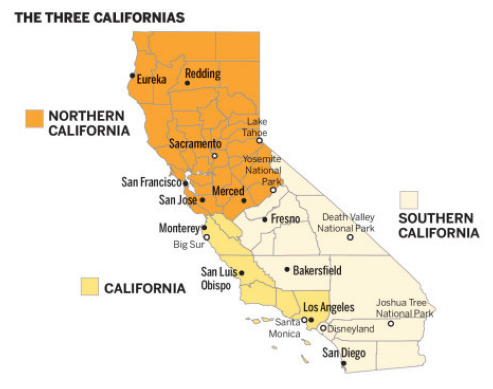

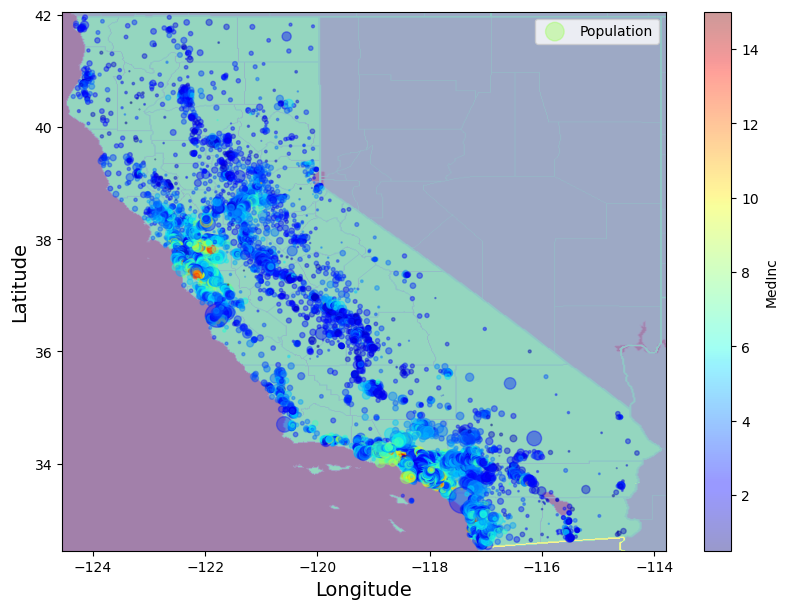

In [5]:
# Hiển thị ảnh
plt.imshow(california_img2)
plt.axis('off')  # Ẩn các trục tọa độ
plt.show()

data_plot = data[['Longitude', 'Latitude', 'Population', 'MedInc']]
data_plot.plot(kind='scatter', x='Longitude', y='Latitude', alpha=0.4,
				s=data_plot['Population']/100, label='Population', figsize=(10,7),
				c='MedInc', cmap=plt.get_cmap('jet'), colorbar=True)


plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05]
           , alpha=0.5) # giới hạn trái và phải - kinh độ (-124.55, -113.80) và vĩ độ (32.45, 42.05)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend() 
plt.show()

###### Hiển thị mối quan hệ giữa các đặc trưng và mục tiêu

In [ ]:
sns.pairplot(data[['MedInc', 'HouseAge', 'AveRooms', 'Population', 'target']], palette='viridis', markers=["o"], plot_kws={'alpha': 0.5})
plt.show()

###### Tính toán Ma trận Tương Quan và Trực Quan Hóa

In [ ]:
# Tính ma trận tương quan
correlation_matrix = data[['AveOccup', 'Population', 'AveBedrms', 'AveRooms', 'HouseAge', 'MedInc', 'target']].corr()

# Vẽ heatmap cho ma trận tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='viridis', square=True, linewidths=.5, cbar_kws={'shrink': .8})
plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục X để tránh chồng chéo
plt.yticks(rotation=0)  # Đảm bảo nhãn trục Y đứng thẳng
plt.title('Ma trận tương quan của các đặc trưng')
plt.tight_layout()  # Tự động điều chỉnh subplot để nó vừa vặn với khu vực hiển thị
plt.show()

###### Chia dữ liệu thành tập huấn luyện (train 80%) và kiểm tra (test 20%)

In [ ]:
# Tạo một đối tượng LabelEncoder
label_encoder = LabelEncoder()

# Giả sử data là DataFrame của bạn và 'Country' là cột cần mã hóa
# Fit và transform cột 'Country' bằng LabelEncoder
data['Country'] = label_encoder.fit_transform(data['Country'])

# Hiển thị các lớp duy nhất đã được mã hóa
print("Classes mapped:", label_encoder.classes_)

# Xem lại DataFrame để đảm bảo cột 'Country' đã được mã hóa
print("\n\n", data['Country'])

# Chỉ định các cột cho X và y
X = data.drop(['target', 'City'], axis=1)
y = data['target']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train

In [ ]:
X_test

In [ ]:
y_train

In [ ]:
y_test

#### Chuẩn hóa dữ liệu

In [ ]:
# Scaling - Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Huấn luyện scaler và biến đổi dữ liệu huấn luyện
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)  # Convert back to DataFrame and add column names
X_test_scaled = scaler.transform(X_test)  # Áp dụng scaler đã huấn luyện cho dữ liệu kiểm tra

In [ ]:
X_train_scaled.head(30)

In [ ]:
X_test_scaled

# Bước 3: Train the model

##### Khởi tạo và huấn luyện mô hình Linear Regression

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

##### Khởi tạo và huấn luyện mô hình Random Forest

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train.values.ravel())

##### Áp dụng GridSearchCV vào mô hình Random Forest của bạn để tinh chỉnh các tham số và tìm ra cấu hình tốt nhất

In [ ]:
# Định nghĩa lưới tham số cho Random Forest
param_grid = {
    'n_estimators': [100, 150],  # Số lượng cây
    'max_features': ['auto', 'sqrt'],  # Số lượng đặc trưng để xem xét tại mỗi phân chia
    'max_depth': [None, 10, 20],  # Độ sâu tối đa của cây
    'min_samples_split': [2, 5],  # Số lượng mẫu tối thiểu cần thiết để phân chia một nút
    'min_samples_leaf': [1, 2]  # Số lượng mẫu tối thiểu tại mỗi lá
}

# Khởi tạo mô hình Random Forest
rf = RandomForestRegressor(random_state=42)

# Cross-validation - Sử dụng GridSearchCV để tìm tham số tốt nhất và thực hiện cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)

# Huấn luyện GridSearchCV với dữ liệu huấn luyện đã chuẩn hóa
grid_search.fit(X_train_scaled, y_train.values.ravel())

# In tham số tốt nhất tìm được
print("Best parameters:", grid_search.best_params_)

# Sử dụng mô hình tối ưu hóa
best_rf_model = grid_search.best_estimator_

##### Khởi tạo và huấn luyện mô hình Gradient Boosting Regressor

In [ ]:
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train_scaled, y_train.values.ravel())

# Bước 4: Evaluate the model

##### Dự đoán và đánh giá 4 mô hình

In [ ]:
predictions = {
    "Linear Regression": lr_model.predict(X_test_scaled),
    "Random Forest": rf_model.predict(X_test_scaled),
    "Gradient Boosting": gb_model.predict(X_test_scaled),
    "Tuned Random Forest": best_rf_model.predict(X_test_scaled)
}

print("""
Score - Độ chính xác

"Linear Regression": {0} %,
"Random Forest": {1} %,
"Gradient Boosting": {2} %,
"Tuned Random Forest": {3} %
""".format(lr_model.score(X_test_scaled, y_test)*100,
          rf_model.score(X_test_scaled, y_test)*100,
          gb_model.score(X_test_scaled, y_test)*100,
          best_rf_model.score(X_test_scaled, y_test)*100))

##### Phân tích sai số và trực quan hóa kết quả

In [ ]:
# Phân tích sai số và trực quan hóa kết quả
print("\n- - - - - - - - - - - - - - - - - - - - - PHÂN TÍCH SAI SỐ VÀ TRỰC QUAN HÓA KẾT QUẢ - - - - - - - - - - - - - - - - - - - - - \n")
i=1
name_models = []
mse_models = []
rmse_models = []
r2_models = []
for name, pred in predictions.items():    
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, pred)
    print(f" - MÔ HÌNH {i}: {name}\n - MSE: {mse:.2f}\n - RMSE: {rmse}\n - R2: {r2:.2f}")
    name_models.append(name)
    mse_models.append(mse)
    rmse_models.append(rmse)
    r2_models.append(r2)
    i = i + 1
    plt.figure(figsize=(10, 4))
    plt.scatter(y_test, pred, alpha=0.3)
    plt.plot([0, 5], [0, 5],'r--')
    plt.title(f"Prediction vs Actual - {name}")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()    

##### Tìm mô hình tốt nhất qua các chỉ số tốt nhất: MSE thấp nhất, RMSE thấp nhất, R2 cao nhất

In [ ]:
print("\n\n= = = = = = = = = = = = = = = TỔNG HỢP - SO SÁNH = = = = = = = = = = = = = = =\n")

# Tìm chỉ số tốt nhất: MSE thấp nhất, RMSE thấp nhất, R2 cao nhất
best_mse_idx = np.argmin(mse_models)
best_rmse_idx = np.argmin(rmse_models)
best_r2_idx = np.argmax(r2_models)

print("""

Mô Hình: {0}

MSE Score: {1}

RMSE Score: {2}

R2 Score: {3}

------------------------------------- 
""".format(name_models,  
           mse_models,     
           rmse_models, 
           r2_models))

# Đưa ra mô hình tốt nhất dựa trên từng chỉ số
print(f"Best model based on MSE: {name_models[best_mse_idx]} (MSE = {mse_models[best_mse_idx]})")
print(f"Best model based on RMSE: {name_models[best_rmse_idx]} (RMSE = {rmse_models[best_rmse_idx]})")
print(f"Best model based on R2 Score: {name_models[best_r2_idx]} (R2 = {r2_models[best_r2_idx]})")

# Xác định mô hình tốt nhất dựa trên sự đồng thuận
scores = [0] * len(name_models)
scores[best_mse_idx] += 1
scores[best_rmse_idx] += 1
scores[best_r2_idx] += 1

# Tìm mô hình với điểm số cao nhất
best_model_index = np.argmax(scores)
print(f"\n => Overall best model for datase California Housing: {name_models[best_model_index]} !!!")

##### Đánh giá mô hình TURNED RANDOM FOREST trên dữ liệu huấn luyện và kiểm thử

In [ ]:
# Dự đoán trên tập huấn luyện
train_preds = best_rf_model .predict(X_train_scaled)
# Dự đoán trên tập kiểm thử
test_preds = best_rf_model .predict(X_test_scaled)

# Đánh giá mô hình trên tập huấn luyện
train_mse = mean_squared_error(y_train, train_preds)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, train_preds)

# Đánh giá mô hình trên tập kiểm thử
test_mse = mean_squared_error(y_test, test_preds)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_preds)

print(f"Train MSE: {train_mse:.2f}, Train RMSE: {train_rmse:.2f}, Train R2: {train_r2:.2f}")
print(f"\nTest MSE: {test_mse:.2f}, Test RMSE: {test_rmse:.2f}, Test R2: {test_r2:.2f}")

##### Lấy ra mức độ quan trọng của từng đặc trưng [RANDOM FOREST]

In [ ]:
# Lấy ra mức độ quan trọng của từng đặc trưng với mô hình Random  
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

# Trực quan hóa

plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x=feature_importances['importance'], y=feature_importances.index, palette="viridis")

# Add values on each bar
for index, value in enumerate(feature_importances['importance']):
    plt.text(value, index, f"{value*100:.2f}%")

plt.title('Importance of Features')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()



##### Lấy ra mức độ quan trọng của từng đặc trưng [TURNED RANDOM FOREST]

In [ ]:
# Lấy ra mức độ quan trọng của từng đặc trưng với mô hình Turned Random  
feature_importances = pd.DataFrame(best_rf_model.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

# Trực quan hóa

plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x=feature_importances['importance'], y=feature_importances.index, palette="viridis")

# Add values on each bar
for index, value in enumerate(feature_importances['importance']):
    plt.text(value, index, f"{value*100:.2f}%")

plt.title('Importance of Features')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()



##### Lấy ra mức độ quan trọng của từng đặc trưng [GRADIENT BOOSTING REGRESSOR]

In [ ]:
# Trích xuất tầm quan trọng của các đặc trưng
feature_importances_gb = pd.DataFrame(gb_model.feature_importances_,
                                      index = X.columns,
                                      columns=['importance']).sort_values('importance', ascending=False)

# Trực quan hóa tầm quan trọng của các đặc trưng
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances_gb['importance'], y=feature_importances_gb.index, palette="viridis")

# Thêm giá trị vào từng thanh (tùy chọn)
for index, value in enumerate(feature_importances_gb['importance']):
    plt.text(value, index, f"{value*100:.2f}%")

plt.title('Importance of Features in Gradient Boosting Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

##### Trích xuất và hiển thị hệ số trong Linear Regression

Với mô hình Linear Regression, việc xác định "tầm quan trọng" của các đặc trưng không giống như với các mô hình dựa trên cây như Random Forest hoặc Gradient Boosting. Thay vào đó, trong Linear Regression, tầm quan trọng của đặc trưng thường được đánh giá qua hệ số (coefficients) của chúng. Hệ số này cho biết mối liên hệ giữa mỗi đặc trưng độc lập và biến mục tiêu, cũng như mức độ ảnh hưởng của đặc trưng đó đối với biến mục tiêu khi tất cả các đặc trưng khác được giữ cố định.

Hệ số (Coefficient): Mỗi hệ số cho biết mức độ thay đổi trung bình dự kiến trong biến mục tiêu (ví dụ, giá nhà) cho một đơn vị thay đổi của đặc trưng tương ứng, giữ nguyên các đặc trưng khác. Nếu hệ số là dương, giá trị của biến mục tiêu sẽ tăng khi đặc trưng tăng; nếu hệ số là âm, giá trị của biến mục tiêu sẽ giảm.

Dương (+): Nếu hệ số là dương, điều đó có nghĩa là có một mối quan hệ dương giữa đặc trưng và giá nhà. Ví dụ, nếu hệ số cho "MedInc" (thu nhập trung bình) là dương, điều đó có nghĩa là càng có thu nhập cao, giá nhà càng cao.

Âm (-): Nếu hệ số là âm, có một mối quan hệ nghịch giữa đặc trưng và giá nhà. Ví dụ, nếu hệ số cho "Population" là âm, điều đó có thể cho thấy rằng khu vực đông dân có thể có giá nhà thấp hơn.

Giá trị tuyệt đối của hệ số: Kích thước của hệ số cho biết mức độ mạnh của ảnh hưởng. Một hệ số lớn (dù dương hay âm) có nghĩa là đặc trưng đó có ảnh hưởng đáng kể đến giá nhà.

Ví dụ: Giả sử chúng ta có một hệ số cho "MedInc" là 0.8, điều này có nghĩa là với mỗi đơn vị tăng của thu nhập trung bình (ví dụ, 10,000 USD), giá nhà trung bình dự kiến tăng thêm 80,000 USD, giữ nguyên các yếu tố khác.

Đặc trưng với thanh dài nhất (dù dương hay âm) là đặc trưng có ảnh hưởng lớn nhất.



In [ ]:
# Trích xuất hệ số của các đặc trưng
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_.flatten()  # Sử dụng flatten() để chuyển ma trận hệ số thành vector
})

# Sắp xếp các hệ số theo giá trị tuyệt đối để xem đặc trưng nào có ảnh hưởng lớn nhất
coefficients = coefficients.sort_values(by='Coefficient', key=abs, ascending=False)

# Trực quan hóa hệ số của các đặc trưng
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette="viridis")
plt.title('Coefficient of Features in Linear Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()


# Bước 5: Use the model

In [ ]:
# Chọn ngẫu nhiên 15 chỉ số từ X_test_scaled
# np.random.seed(100)
random_indices = np.random.choice(X_test_scaled.shape[0], size=15, replace=False)

# Lấy mẫu dữ liệu từ X_test và X_test_scaled dùng các chỉ số ngẫu nhiên
random_samples = X_test.iloc[random_indices]  # Lấy từ X_test không chuẩn hóa
random_samples_scaled = X_test_scaled[random_indices]  # Lấy từ X_test đã chuẩn hóa

# Dự đoán giá nhà cho các mẫu được chọn - TURNED RANDOM FOREST
predicted_prices = best_rf_model.predict(random_samples_scaled)

# Chuẩn bị DataFrame để hiển thị kết quả
results_df = random_samples.copy()  # Sao chép thông tin của các mẫu
results_df['Actual Price'] = y_test.iloc[random_indices].values * 100000  # Giá nhà thực tế
results_df['Predicted Price'] = predicted_prices * 100000  # Giá nhà dự đoán
# +: THỰC TẾ > DỰ ĐOÁN
# -: THỰC TẾ - DỰ ĐOÁN
results_df['Difference'] = results_df['Actual Price'] - results_df['Predicted Price']

# Định dạng cột giá thành dạng tiền tệ USD
results_df['Actual Price'] = results_df['Actual Price'].apply(lambda x: f"${x:.2f}")
results_df['Predicted Price'] = results_df['Predicted Price'].apply(lambda x: f"${x:.2f}")
results_df['Difference'] = results_df['Difference'].apply(lambda x: f"${x:.2f}")

# In kết quả chi tiết
results_df